### Import Various Libraries To start with Analysis

In [1]:
#Below are Pyspark Libraries to create and run SPARK Session locally
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CreditCardAnalysis").getOrCreate()

#Importing Math library to run Log functions in WOE_IV class
import math

#Importing various Pyspark libraries for column, when, average and Dataframe datatype
import pyspark.sql.types
from pyspark.sql.functions import col,when,avg
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

#Import pyspark stringindexer libary to convert string category to integer category, vector assembler
#for creating vector column for model input and bucketizer to bucket highly skewed integer columns
from pyspark.ml.feature import StringIndexer, VectorAssembler, Bucketizer

# import the logistic model
from pyspark.ml.classification import LogisticRegression

#Import Python Pandas/Visualization Libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Call SPARK session to get details and spark UI for job performance analysis

In [2]:
spark

Read Application CSV file into Spark Dataframe

In [3]:
dfApp = spark.read.csv("application_record.csv", header=True, inferSchema=True)

### Below are EDA Questions

As part of the EDA, report your observations for the following questions:

1. What is the proportion of females in the applicant customer base?

2. Is homeownership higher among male applicants or female applicants?

3. Is there any correlation between the customer's income level and education level?

4. What is the average and median salary of the applicant base?

5. Is the proportion of bad customers higher for people who own cars?

6. Is the proportion of bad customers higher for those living on rent than the rest of the population?

7. Is the proportion of bad customers higher for those who are single than married customers?

In [4]:
tot = dfApp.count()

#### What is the proportion of females in the applicant customer base?

In [5]:
dfApp.groupBy("CODE_GENDER").count().withColumn('PROPORTION',col('count')/tot).show()

+-----------+------+------------------+
|CODE_GENDER| count|        PROPORTION|
+-----------+------+------------------+
|          F|294440|0.6713836513839706|
|          M|144117|0.3286163486160294|
+-----------+------+------------------+



## Answer : Female proportion is 67% compared to male 33%

#### Is homeownership higher among male applicants or female applicants?

In [6]:
dfApp.filter(dfApp["NAME_HOUSING_TYPE"] == "House / apartment").groupBy("CODE_GENDER").count().show()

+-----------+------+
|CODE_GENDER| count|
+-----------+------+
|          F|267607|
|          M|126224|
+-----------+------+



## Answer : Female applicants are higher

#### Is there any correlation between the customer's income level and education level?

Converting Education Column into Categorical Integer Column
Converting Annual Salary to Monthly Salary to understand the pattern
Convert DAYS_BIRTH and DAYS_EMPLOYED to Age and Number of years employed by dividing them to -365

In [7]:
dfApp = dfApp.withColumn("NAME_EDUCATION_TYPE",
                         when(dfApp.NAME_EDUCATION_TYPE == "Academic degree",4).
                         when(dfApp.NAME_EDUCATION_TYPE == "Lower secondary",0).
                         when(dfApp.NAME_EDUCATION_TYPE == "Incomplete higher",2).
                         when(dfApp.NAME_EDUCATION_TYPE == "Higher education",3).
                         when(dfApp.NAME_EDUCATION_TYPE == "Secondary / secondary special",1))

dfApp = dfApp.withColumn("MONTHLY_SALARY",col('AMT_INCOME_TOTAL')/12)
dfApp = dfApp.withColumn("AGE",col('DAYS_BIRTH')/-365)
dfApp = dfApp.withColumn("EMP_YEARS",col('DAYS_EMPLOYED')/-365)

In [8]:
dfApp.corr("MONTHLY_SALARY","NAME_EDUCATION_TYPE")

0.22140334581321044

## Answer : Yes There is a positive correlation means as the Education Increases,
## Salary also Increases

#### What is the average and median salary of the applicant base?

In [9]:
dfApp.agg(avg(col("AMT_INCOME_TOTAL"))).show()

+---------------------+
|avg(AMT_INCOME_TOTAL)|
+---------------------+
|   187524.28600950394|
+---------------------+



## Answer : 1,87,524

#### What is the average and median salary of the applicant base?

In [10]:
dfApp.approxQuantile('AMT_INCOME_TOTAL', [0.5], 0.25)

[157500.0]

## Answer : 1,57,500

### Reading Credit Record CSV File to answer rest of EDA questions to understand proportion of good and bad customers

In [11]:
dfCre = spark.read.csv("credit_record.csv", header=True, inferSchema=True)

Rename the ID Column Name so that after Inner Join, redundant columns should not come in same DAtaframe and easy to 
drop redundant Column Name after Matching

In [12]:
dfCre_N = dfCre.withColumnRenamed('ID','IDcre')

Perform Inner Join between 2 Dataframe to generate common entries

In [13]:
df = dfApp.join(dfCre_N, dfApp.ID == dfCre_N.IDcre,'inner')

Drop Redundant column 'ID' based on which we did join

In [14]:
dfNew = df.drop('IDcre')

Get total number of records to calculate proportions

In [15]:
tot = dfNew.count()

Convert STATUS or DELINQUENT Column into Good and Bad Customer by assigning C to -1 and X to -2 so it becomes an integer
column.
Then apply generic rule of assigning -2,-1,0 and 1 as "1" equivalent to good customer and 2,3,4,5 as "0" equivalent to
bad customer.

In [16]:
dfNew = dfNew.withColumn('STATUS',when((col('STATUS') == 'C'),-1).when((col('STATUS') == 'X'),-2).otherwise(col('STATUS')))

dfNew = dfNew.withColumn('STATUS',col('STATUS').cast('int'))

dfNew = dfNew.withColumn('STATUS_N',when((col('STATUS') <= 1),1).otherwise(0))

#### Is the proportion of bad customers higher for people who own cars?

In [17]:
dfNew.groupBy('FLAG_OWN_CAR','STATUS_N').count().withColumn('PROPORTION', col('count')/tot).\
      sort('PROPORTION', ascending=False).show(truncate=False)

+------------+--------+------+---------------------+
|FLAG_OWN_CAR|STATUS_N|count |PROPORTION           |
+------------+--------+------+---------------------+
|N           |1       |471655|0.6064625216178163   |
|Y           |1       |303232|0.3899011848813511   |
|N           |0       |1700  |0.0021858907183222647|
|Y           |0       |1128  |0.0014504027825103026|
+------------+--------+------+---------------------+



## Answer : No. Proportion of bad customer having car is 0.0014 which is < 0.38

#### Is the proportion of bad customers higher for those living on rent than the rest of the population?

In [18]:
dfNew.groupBy('NAME_HOUSING_TYPE','STATUS_N').count().withColumn('PROPORTION', col('count')/tot).\
      sort('PROPORTION',ascending=False).show(truncate=False)

+-------------------+--------+------+---------------------+
|NAME_HOUSING_TYPE  |STATUS_N|count |PROPORTION           |
+-------------------+--------+------+---------------------+
|House / apartment  |1       |694682|0.8932346682267925   |
|With parents       |1       |35630 |0.045813697819895464 |
|Municipal apartment|1       |24491 |0.03149097034260622  |
|Rented apartment   |1       |10853 |0.013954983509383257 |
|Office apartment   |1       |5606  |0.007208296098185068 |
|Co-op apartment    |1       |3625  |0.0046610905023048285|
|House / apartment  |0       |2469  |0.003174684813845689 |
|Municipal apartment|0       |149   |1.915868923705985E-4 |
|With parents       |0       |105   |1.3501089730813987E-4|
|Rented apartment   |0       |45    |5.786181313205994E-5 |
|Office apartment   |0       |30    |3.8574542088039964E-5|
|Co-op apartment    |0       |30    |3.8574542088039964E-5|
+-------------------+--------+------+---------------------+



## Answer : No. Proportion of bad customer on rent is very less when compared to population

#### Is the proportion of bad customers higher for those who are single than married customers?

In [19]:
dfNew.groupBy('NAME_FAMILY_STATUS','STATUS_N').count().withColumn('PROPORTION',col('count')/tot).\
      sort('PROPORTION',ascending=False).show(truncate=False)

+--------------------+--------+------+---------------------+
|NAME_FAMILY_STATUS  |STATUS_N|count |PROPORTION           |
+--------------------+--------+------+---------------------+
|Married             |1       |544666|0.7003413846974792   |
|Single / not married|1       |93887 |0.12072160110066027  |
|Civil marriage      |1       |60236 |0.07745253724050584  |
|Separated           |1       |45084 |0.057969821849906455 |
|Widow               |1       |31014 |0.03987836161061571  |
|Married             |0       |1953  |0.0025112026899314016|
|Single / not married|0       |448   |5.760464951813967E-4 |
|Separated           |0       |171   |2.198748899018278E-4 |
|Widow               |0       |150   |1.9287271044019983E-4|
|Civil marriage      |0       |106   |1.362967153777412E-4 |
+--------------------+--------+------+---------------------+



## Answer : No. Proportion of single bad customer is 0.0005 which is < married of 0.002

### ------------------------ EDA Completed -------------------------- ###

### Checking FLAG_MOBIL column since it contains single data and not significant in Logistic Regression analysis

In [20]:
dfNew.groupBy('FLAG_MOBIL').count().show()

+----------+------+
|FLAG_MOBIL| count|
+----------+------+
|         1|777715|
+----------+------+



### Checking OCCUPATION Type column since it has lot of nulls

In [21]:
dfNew.groupBy('OCCUPATION_TYPE').count().show()

+--------------------+------+
|     OCCUPATION_TYPE| count|
+--------------------+------+
|                null|240048|
|            Managers| 67738|
|            HR staff|  1686|
|      Medicine staff| 26691|
|         Accountants| 27223|
|            Laborers|131572|
|      Cleaning staff| 11399|
|Private service s...|  6714|
|             Drivers| 47678|
|         Sales staff| 70362|
|       Realty agents|  1260|
|            IT staff|  1319|
|      Security staff| 12400|
|         Secretaries|  3149|
|  Low-skill Laborers|  3623|
|          Core staff| 77112|
|       Cooking staff| 13416|
|High skill tech s...| 31768|
|Waiters/barmen staff|  2557|
+--------------------+------+



#### Converting Gender String into Integer CAtegorical Column
#### Converting Car Owned into Integer CAtegorical Column
#### Converting Realty Owned into Integer CAtegorical Column

#### Filling Null Occupational Columns by Income Type Source since Occupational Type Column has lot of nulls

In [22]:
dfNewCC = dfNew.withColumn('CODE_GENDER',when((col('CODE_GENDER') == 'M'),1).otherwise(0))

dfNewCC = dfNewCC.withColumn('FLAG_OWN_CAR',when((col('FLAG_OWN_CAR') == 'Y'),1).otherwise(0))

dfNewCC = dfNewCC.withColumn('FLAG_OWN_REALTY',when((col('FLAG_OWN_REALTY') == 'Y'),1).otherwise(0))

dfNewCC = dfNewCC.withColumn('FIN_OCC_TYPE',when(df['OCCUPATION_TYPE'].isNull(),
                                                 df['NAME_INCOME_TYPE']).otherwise(df['OCCUPATION_TYPE']))

#### Bucketizing Age Column into different Buckets/Bins

In [23]:
bucketizer = Bucketizer(splits=[ 0, 20, 30, 40, 50, 60, float('Inf') ],inputCol="AGE", outputCol="AGE_BIN")
dfNewCC = bucketizer.setHandleInvalid("keep").transform(dfNewCC)

#### Bucketizing Years Employed Column into different Buckets/Bins

In [24]:
bucketizer1 = Bucketizer(splits=[ -float('Inf'), 0, 5, 10, 15, 20, 25, float('Inf') ],inputCol="EMP_YEARS", outputCol="EMP_YRS_BIN")
dfNewCC = bucketizer1.setHandleInvalid("keep").transform(dfNewCC)

#### Bucketizing Salary Column into different Buckets/Bins
#### Choosing Salary Bin is not straightforward since number of applicants in lower income range are high compared to
#### applicants with higher salary income

In [25]:
bucketizer2 = Bucketizer(splits=[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 25000, 30000, float('Inf') ],
                         inputCol="MONTHLY_SALARY", outputCol="MNTH_SAL_BIN")
dfNewCC = bucketizer2.setHandleInvalid("keep").transform(dfNewCC)

#### Running String Indexer of String Categorical Columns to split them into Integer Categorical Column
#### for Logistic Regression

In [26]:
# run the string indexer on the columns which are categorical but are represented by strings.
# adding a string on the end of the output column to make it easy to identify

stringCols = ['NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FIN_OCC_TYPE']
for c in stringCols:
    outCol = c + '_ix'
    si = StringIndexer(inputCol=c, outputCol=outCol)
    dfNewCC = si.fit(dfNewCC).transform(dfNewCC)

#### Dropping all String Categorical columns 'NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE'
#### 'OCCUPATION_TYPE'
#### Dropping columns which are transformed 'DAYS_BIRTH','DAYS_EMPLOYED','STATUS','OCCUPATION_TYPE'
#### Dropping columns which are binned 'MONTHLY_SALARY','FIN_OCC_TYPE','AGE','EMP_YEARS'
#### Dropping unwanted columns 'ID','FLAG_MOBIL'

In [27]:
dfNewCC = dfNewCC.drop('NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                     'STATUS','ID','FLAG_MOBIL','AMT_INCOME_TOTAL','OCCUPATION_TYPE',
                      'AGE','EMP_YEARS','DAYS_BIRTH','DAYS_EMPLOYED','FIN_OCC_TYPE','MONTHLY_SALARY')

### Convert into PANDAS to gather our undestanding from Correlation HeatMap

In [28]:
dfPD = dfNew.toPandas()

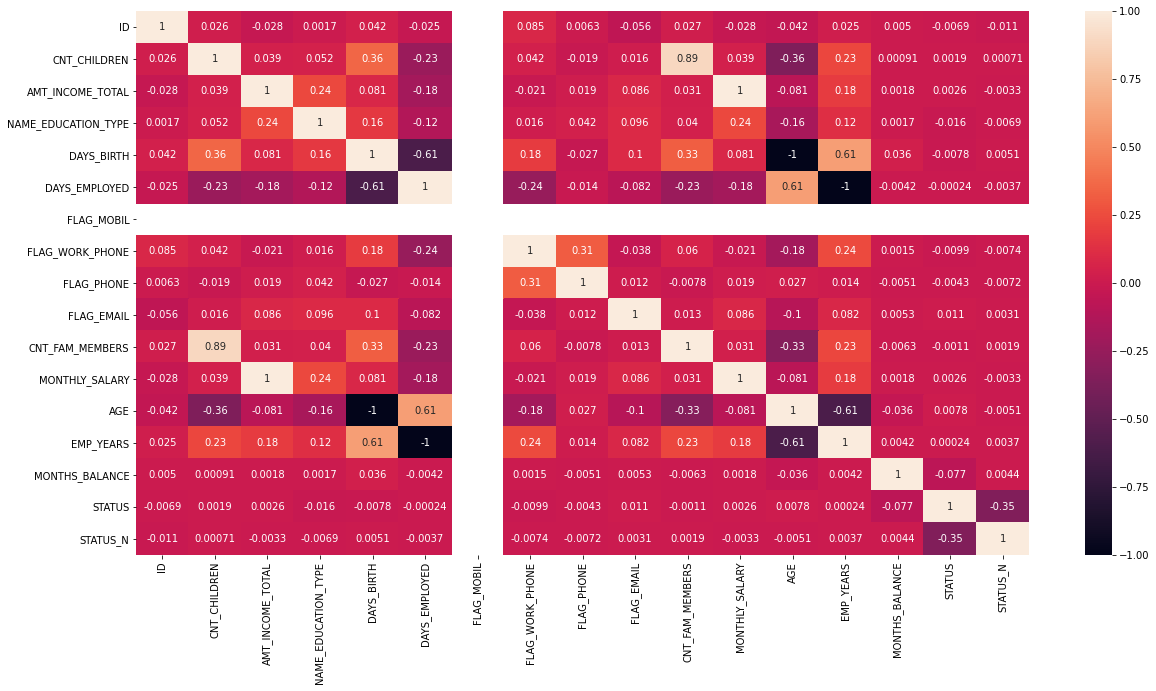

In [29]:
plt.figure(figsize = (20,10))
sns.heatmap(dfPD.corr(),annot=True)
plt.show()

##### -> Since FLAG_MOBIL was constant, we dropped this column.
##### -> As Days employed and birth was transformed to AGE and Employment Years, annual income to monthly income, they have -1 and 1 correlation value respectively.
##### -> There is a direct relation between number of children and number of days employed
##### -> There is a direct relation between age and number of family members
##### -> A Very high correlation between number of family members and number of childrens in them
##### -> A good correlation or trend between as Age increases, number of days employed and and education level increases
##### -> A lot of columns shows increasing trend with increasing employment years

In [30]:
dfPD2 = dfNewCC.toPandas()

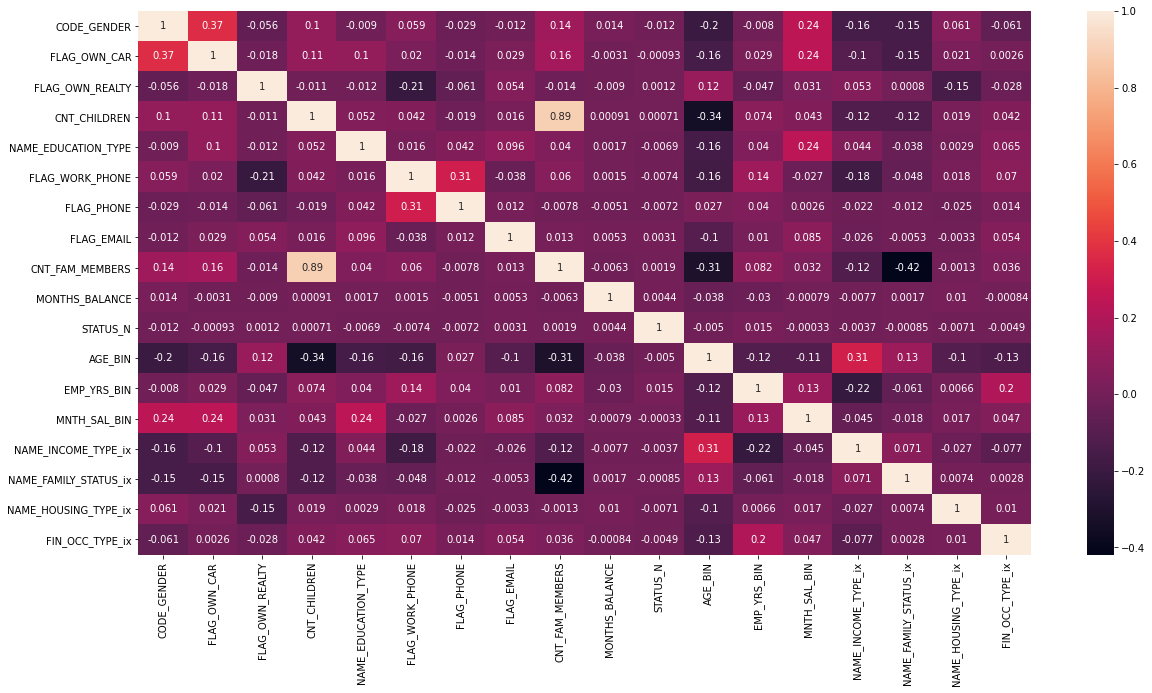

In [31]:
plt.figure(figsize = (20,10))
sns.heatmap(dfPD2.corr(),annot=True)
plt.show()

Pyspark WOE_IV Class

In [32]:
class WOE_IV(object):
    
    """
    This class contains methods that are used for calculating the WOE and IV values in a given dataset.
    
    Attributes
    ----------
    df : spark DataFrame
        The spark dataframe
    cols_to_woe : list
        Columns that you want to convert in WOE and IV
    label_column : str
        target column of the data
    good_label : str
        Predicted variable in the form of 1 or 0
    """
    
    def __init__(self, df: DataFrame, cols_to_woe: [str], label_column: str, good_label: str):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {} # This is a dictionary which will store all the WOE and IV computed in the latter part of the code

    def fit(self):  
        """
        This method takes the columns in 'cols_to_woe' and calculates the good and bad amounts, and then assigns the 
        WOE values in the dictionary, 'fit_data'
        """
        for col_to_woe in self.cols_to_woe: # Iterating over each column in the list, cols_to_woe
            
            total_good = self.compute_total_amount_of_good() # Computes the total amount of good labels in the entire dataset
            total_bad = self.compute_total_amount_of_bad() # Computes the total amount of bad labels in the entire dataset
            
            woe_df = self.df.select(col_to_woe) # This dataframe stores the column, col_to_woe from the DataFrame
            categories = woe_df.distinct().collect() # Creates a list of all the distinct categories in the column, col_to_woe
            for category_row in categories: # Iterating over each category in the distinct categories of the column
                category = category_row[col_to_woe]
                
                # For each category, we calculate the good_amount and bad_amount
                good_amount = self.compute_good_amount(col_to_woe, category)
                bad_amount = self.compute_bad_amount(col_to_woe, category)
                
                # If the good_amount or bad_amount is 0, we replace it with 0.5, because in the calculation of woe, 
                #it comes in the denominator resulting in a Nan value which will give an error
                good_amount = good_amount if good_amount != 0 else 0.5
                bad_amount = bad_amount if bad_amount != 0 else 0.5

                # Calculating the fraction of good_amount and bad_amount specific to that category
                good_dist = good_amount / total_good
                bad_dist = bad_amount / total_bad

                # Calling the build_fit_data method which calculates the WOE and IV for the category in the column and 
                #stores it in the dictionary, fit_data
                self.build_fit_data(col_to_woe, category, good_dist, bad_dist)

    def transform(self, df: DataFrame):
        """
        This method creates a column called "col_to_woe + '_woe'" which replaces the given category value with the WOE value.
        It finally returns a final dataframe containing the WOE values in place of the columns
        """
        def _encode_woe(col_to_woe_):
            return F.coalesce(
                *[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe']))
                  for category, woe_iv in self.fit_data[col_to_woe_].items()]
            )

        for col_to_woe, woe_info in self.fit_data.items():
            # Adds another column to the df containing the final WOE values
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
     # Computes the total amount of good labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
     # Computes the total amount of bad labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
     # Computes the total amount of good labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label)
                      ).count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        # Computes the total amount of bad labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label)
                      ).count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        """
        Calculates the WOE and value for the specific category and saves it in the woe_info dictionary which is saves in 
        the fit_data dictionary
        
        
        Attributes:
        col_to_woe: str
        name of the feature
        
        category: str
        Class of that feature
        
        good_dist: float
        Fraction of good labels specific to that category
        
        bad_dist: float
        Fraction of bad labels specific to that category
        """
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist), # Calculating the WOE value for the category in the column
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist) # Calculating the IV value for the category 
                                                                                #in the column
            }
        }

        # Adding the feature, col_to_woe to fit_data if not present already
        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        """
        Returns the IV dictionary which contains the IV value for each feature
        """
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv'] # IV for the feature = IV value for the indiviual categories of the 
                                                # feature (column)
        return iv_dict

Create Object of the Class

In [33]:
dfWOEIV = WOE_IV(dfNewCC,['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN',
                          'NAME_EDUCATION_TYPE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','CNT_FAM_MEMBERS',
                          'MNTH_SAL_BIN','MONTHS_BALANCE','NAME_INCOME_TYPE_ix',
                          'NAME_FAMILY_STATUS_ix','NAME_HOUSING_TYPE_ix','FIN_OCC_TYPE_ix','AGE_BIN',
                          'EMP_YRS_BIN'],'STATUS_N',1)

Call Fit Method to Calculate WOE

In [34]:
dfWOEIV.fit()

Call Compute IV Method to Calculate and Fetch IV Values for Feature Engineering

In [35]:
dfWOEIV.compute_iv()

{'CODE_GENDER': 0.03679191095260092,
 'FLAG_OWN_CAR': 0.0002381548065452438,
 'FLAG_OWN_REALTY': 0.00041314523412768107,
 'CNT_CHILDREN': 0.016217888179412093,
 'NAME_EDUCATION_TYPE': 0.031612391011036654,
 'FLAG_WORK_PHONE': 0.014156449393518485,
 'FLAG_PHONE': 0.01372456561875916,
 'FLAG_EMAIL': 0.0027804559765888253,
 'CNT_FAM_MEMBERS': 0.014452888467228689,
 'MNTH_SAL_BIN': 0.0806225420209064,
 'MONTHS_BALANCE': 0.039302004383835215,
 'NAME_INCOME_TYPE_ix': 0.08216109370064278,
 'NAME_FAMILY_STATUS_ix': 0.04332026889315491,
 'NAME_HOUSING_TYPE_ix': 0.019676965190374568,
 'FIN_OCC_TYPE_ix': 0.21280494311663098,
 'AGE_BIN': 0.02090801155863633,
 'EMP_YRS_BIN': 0.1500039940294895}

Call Transform Method to add WOE of respective columns into new Dataframe

In [36]:
dfFinal = dfWOEIV.transform(dfNewCC)

consider predictors with IV values less than 0.002 to be insignificant in the modelling process.

Also Drop rest of the categorical columns once WOE are calculated and Transformed

In [37]:
dfFinalData = dfFinal.drop('FLAG_OWN_CAR','FLAG_OWN_CAR_woe','FLAG_OWN_REALTY','FLAG_OWN_REALTY_woe','CODE_GENDER',
                           'CNT_CHILDREN','NAME_EDUCATION_TYPE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','CNT_FAM_MEMBERS',
                           'MONTHLY_SALARY','MONTHS_BALANCE','NAME_INCOME_TYPE_ix','NAME_FAMILY_STATUS_ix',
                           'NAME_HOUSING_TYPE_ix','AGE_BIN','EMP_YRS_BIN','FIN_OCC_TYPE_ix')

Create Vector Assember Column to get all input columns as Vector for Pyspark Logistic Regression Model Training

In [38]:
# use the vector assember to combine all the encoded columns and the continuous variable columns 

# add the neumerical columns to the list of encoded traning columns
trainCols = dfFinalData.columns
trainCols.remove('STATUS_N')

#configure the assembler object and use it to transform df
assembler = VectorAssembler(inputCols=trainCols, outputCol='features')
dfFinalData = assembler.transform(dfFinalData)

Split The Dataset into training and test dataset

In [39]:
# split the data into training and testing data set

df_train, df_test = dfFinalData.randomSplit([0.7,0.3])

Call Logistic Regression Model and pass input/output columns

In [40]:
# train model in the training dataset

# create the logistic model, configure it and call fit it to the data. 
lr = LogisticRegression(featuresCol='features', labelCol='STATUS_N')
model = lr.fit(df_train)

Evaluate Logistic Regression Model Performance on Training Dataset

In [41]:
s1 = model.evaluate(df_train)

Get Performance Parameters of Logistic Model like Area Under ROC, FP, TP and Recall of Training Dataset

In [42]:
print("accuracy : ",s1.accuracy)
print("Area under ROC : ",s1.areaUnderROC)
print("FP(False Positive Rate) : ",s1.falsePositiveRateByLabel)
print("TP(True Positive Rate) : ",s1.truePositiveRateByLabel)
print("Recall : ",s1.recallByLabel)
print("Weighted Recall : ",s1.weightedRecall)
print("WPF(Weighted False Positive Rate) : ",s1.weightedFalsePositiveRate)
print("WTP(Weighted True Positive Rate) : ",s1.weightedTruePositiveRate)
print("Precision : ",s1.weightedPrecision)

accuracy :  0.9963333376175324
Area under ROC :  0.6935320061398305
FP(False Positive Rate) :  [0.0, 1.0]
TP(True Positive Rate) :  [0.0, 1.0]
Recall :  [0.0, 1.0]
Weighted Recall :  0.9963333376175324
WPF(Weighted False Positive Rate) :  0.9963333376175324
WTP(Weighted True Positive Rate) :  0.9963333376175324
Precision :  0.9926801196480919


Evaluate Same Logistic Regression Model Performance on Test Dataset

In [43]:
# use the model to predict the class labels of test data. 

s2 = model.evaluate(df_test)

Get Performance Parameters of Same Logistic Model like Area Under ROC, FP, TP and Recall on Test Dataset

In [44]:
print("accuracy : ",s2.accuracy)
print("Area under ROC : ",s2.areaUnderROC)
print("FP(False Positive Rate) : ",s2.falsePositiveRateByLabel)
print("TP(True Positive Rate) : ",s2.truePositiveRateByLabel)
print("Recall : ",s2.recallByLabel)
print("Weighted Recall : ",s2.weightedRecall)
print("WPF(Weighted False Positive Rate) : ",s2.weightedFalsePositiveRate)
print("WTP(Weighted True Positive Rate) : ",s2.weightedTruePositiveRate)
print("Precision : ",s2.weightedPrecision)

accuracy :  0.9964346699388188
Area under ROC :  0.7069044354345411
FP(False Positive Rate) :  [0.0, 1.0]
TP(True Positive Rate) :  [0.0, 1.0]
Recall :  [0.0, 1.0]
Weighted Recall :  0.9964346699388188
WPF(Weighted False Positive Rate) :  0.9964346699388188
WTP(Weighted True Positive Rate) :  0.9964346699388188
Precision :  0.9928820514560827
